# Waving Goodbye to Subsequent COVID-19 Waves
### Using data from the Government of Canada on daily cases and daily vaccinations to model the end of the pandemic in Canada

**Disclaimer**: Please note that this project is just for fun and for my personal learning. Although the data is publicly retrievable, these analyses should __not__ be used to guide real-world decisions. Models use an idealized input and are not adequate representations of human behaviour. 

## Part 1. Data Retrieval
The first thing to do is to retrieve data from the Government of Canada websites

In [1]:
# Import dependencies
import datetime
import missingno as msno
import matplotlib.pyplot as plt
import os
import pandas as pd
import urllib

In [2]:
# Make a directory to hold the data if it doesn't exist
if not os.path.exists("../data"):
    os.makedirs("../data")

So now we will have to define a function that takes as input a remote URL containing our desired data_source and our output filename.

In [3]:
def download(remote_url: str, local_file: str):
    """Download a file from a remote URL unless the local_file already exists.
    Returns the local_file name."""
    if not os.path.exists(local_file):
        print(f"Retrieving {local_file}...")
        response = urllib.request.urlretrieve(remote_url, local_file)
        return local_file

In [4]:
# Set target datasets to download for our database
# Thankfully, these databases are in .csv format
url_prefix = "https://health-infobase.canada.ca/src/data/covidLive/"
files_list = ['covid19-download.csv', 'covid19-data-dictionary.csv', 'vaccination-coverage-map.csv']

# Get the current time
now = datetime.datetime.utcnow()

# Then download the datasets
for file in files_list:
    if not os.path.exists("../data/" + file):
        download(url_prefix + file, "../data/" + file)
    else:
        # Get the time of modification for the target file
        last_updated = datetime.datetime.utcfromtimestamp(os.path.getctime("../data/" + file))
        
        # If the age of the file is >1 week old,
        # delete the old file and download a new one from the source
        age = now - last_updated

        if age.days > 7:
            print(f"{file} is >1 week old at {age.days} days. Redownloading {file} from source...")
            os.remove("../data/" + file)
            download(url_prefix + file, "../data/" + file)
        else:
            print(f"{file} is <1 week old at {age.days} days.")

covid19-download.csv is <1 week old at 0 days.
covid19-data-dictionary.csv is <1 week old at 0 days.
vaccination-coverage-map.csv is <1 week old at 0 days.


Now that we have our datasets, let's transfer them into a dataframe and see what's inside:

In [5]:
# Read all our data into separate dataframes
data_dict = pd.read_csv('../data/covid19-data-dictionary.csv')
epi_data = pd.read_csv('../data/covid19-download.csv')
vax_data = pd.read_csv('../data/vaccination-coverage-map.csv')

data_dict

,Column Header,Variable Name,Description
0,pruid,Provincial ID,1=Canada \r\n10=Newfoundland and Labrador\r\n1...
1,prname,Province name,Name of P/T (English)
2,prnameFR,Province name,Name of P/T (French)
3,date,Report date,Date reported by P/T
4,numconf,Number of confirmed cases,Number of confirmed cases in each P/T (Canada=...
5,numprob,Number of probable cases,Number of probable cases in each P/T (Canada= ...
6,numdeaths,Number of deaths,Number of deaths in each P/T (Canada= sum of a...
7,numtotal,Total number of cases,Calculated by number of confirmed cases plus n...
8,numtested,Number of individuals tested,"Number of individuals tested in each P/T, as r..."
9,numrecover,Number of recovered cases,Number of recovered cases in each P/T (Canada=...


In [6]:
# Take a look at what's inside one of the dataframes
epi_data.head(10)

,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,1,Canada,Canada,2020-02-08,NaN,7,0.0,0.0,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,35,Ontario,Ontario,2020-02-16,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,59,British Columbia,Colombie-Britannique,2020-02-16,NaN,5,0.0,0.0,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,1,Canada,Canada,2020-02-16,NaN,8,0.0,0.0,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,35,Ontario,Ontario,2020-02-21,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


It looks like `data_dict` is a dictionary for the column headers for `epi_data`. Let's define them outside here: 

| Column Header | Variable Name | Description | 
| :--- | :--- | :--- |
| **pruid** | Provincial ID | 1=Canada <br> 10=Newfoundland and Labrador <br> 11=Prince Edward Island <br> 12=Nova Scotia <br> 13=New Brunswick <br> 24=Quebec <br> 35=Ontario <br> 46=Manitoba <br> 47=Saskatchewan <br> 48=Alberta <br> 59=British Colombia <br> 60=Yukon <br> 61=Northwest Territories <br> 62=Nunavut <br> 99=Repatriated Travellers |
| **prname** | Province name | Name of P/T (English) |
| **prnameFR** | Province name | Name of P/T (French) |  
| **date** | Report date | Date reported by P/T |
| **numconf** | Number of confirmed cases | Number of confirmed cases in each P/T (Canada= sum of all P/Ts) |
| **numprob** | Number of probable cases | Number of probable cases in each P/T (Canada= sum of all P/Ts) | 
| **numdeaths** | Number of deaths | Number of deaths in each P/T (Canada= sum of all P/Ts) |
| **numtotal** | Total number of cases | Calculated by number of confirmed cases plus number of probable cases (numconf+numprob) |
| **numtested** | Number of individuals tested | Number of individuals tested in each P/T, as reported from the National Microbiology Laboratory |
| **numrecover** | Number of recovered cases | Number of recovered cases in each P/T (Canada=sum of all P/Ts) | 
| **percentrecover** | Percentage of recovered cases | Calculated by the number of recovered cases for a P/T divided by the total number of confirmed cases for that P/T [(numrecover/numtotal) x100] |
| **ratetested** | Testing rate per one million population | Calculated by the number of individuals tested for a P/T divided by the population of that P/T [(numtested/population) x1,000,000] |
| **numtoday** | Number of new cases since last update | Number of total counts from last update subtracted from total counts of current update |
| **percentoday** | Percent change since last update | Calculated by the number of new cases divided by the previous update's total number of cases [(numtoday/numtotal of previous update)x100] |
| **ratetotal** | Case rate per one hundred thousand population | Calculated by the total number of cases for a P/T divided by the population of that P/T[(numtotal/population) x100,000] |

In [7]:
# Describe the rest of the epidemiological data
epi_data.describe()

,pruid,update,numconf,numprob,numdeaths,numtotal,numtested,numtests,numrecover,percentrecover,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
count,9762.000000,4654.000000,9.762000e+03,6312.000000,9643.000000,9.762000e+03,4.905000e+03,9.762000e+03,9.238000e+03,9034.000000,...,8876.000000,9510.000000,8876.000000,9510.000000,8875.000000,9510.000000,8876.000000,9510.000000,8876.000000,9115.000000
mean,39.153862,0.809626,1.042552e+05,1.039924,2322.633205,1.042555e+05,8.376140e+05,2.906520e+06,1.030575e+05,89.185910,...,1.073958,2717.864564,40.634384,44.097371,0.538767,388.253838,5.804988,6.283176,0.076830,5.513139
std,26.269873,0.392638,2.719686e+05,16.599030,5392.935149,2.719686e+05,2.277015e+06,7.405396e+06,2.663213e+05,15.503701,...,1.990395,7055.570938,64.703590,128.495046,1.057237,1007.943167,9.243358,18.364443,0.151013,13.864734
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-49.250000
25%,12.000000,1.000000,1.280000e+02,0.000000,0.000000,1.280000e+02,4.464000e+03,1.165150e+04,1.650000e+02,87.310000,...,0.000000,2.000000,1.500000,0.000000,0.000000,0.000000,0.210000,0.000000,0.000000,0.000000
50%,46.000000,1.000000,1.499500e+03,0.000000,30.000000,1.499500e+03,5.729200e+04,1.981605e+05,1.530500e+03,94.150000,...,0.230000,73.000000,11.010000,1.000000,0.100000,10.000000,1.570000,0.000000,0.010000,0.650000
75%,60.000000,1.000000,5.932175e+04,0.000000,1420.000000,5.932175e+04,3.741220e+05,1.337536e+06,5.776525e+04,97.660000,...,1.270000,2111.750000,58.160000,23.000000,0.590000,302.000000,8.310000,3.000000,0.080000,6.330000
max,99.000000,1.000000,1.866907e+06,833.000000,30032.000000,1.866907e+06,1.748336e+07,5.063583e+07,1.788221e+06,100.780000,...,17.400000,61113.000000,773.560000,1236.000000,9.000000,8730.000000,110.510000,177.000000,1.290000,435.130000


In [8]:
# Describe the vaccination coverage data
vax_data.describe()

,pruid,numtotal_atleast1dose,numtotal_partially,numtotal_fully,proptotal_atleast1dose,proptotal_partially,proptotal_fully,numeligible_atleast1dose,numeligible_partially,numeligible_fully,...,num5plus_atleast1dose,num5plus_partially,num5plus_fully,prop5plus_atleast1dose,prop5plus_partially,prop5plus_fully,numweekdelta_atleast1dose,numweekdelta_fully,propweekdelta_atleast1dose,propweekdelta_fully
count,721.000000,7.210000e+02,7.120000e+02,7.070000e+02,721.000000,712.000000,707.000000,3.920000e+02,3.830000e+02,3.920000e+02,...,3.920000e+02,3.830000e+02,3.920000e+02,392.000000,383.000000,392.000000,0.0,0.0,0.0,0.0
mean,34.973648,2.552601e+06,7.539285e+05,1.837514e+06,47.808655,12.364663,35.682645,3.973437e+06,7.493701e+05,3.229912e+06,...,3.983174e+06,7.581656e+05,3.231055e+06,76.276786,12.864935,62.557832,NaN,NaN,NaN,NaN
std,21.678923,5.867068e+06,2.250177e+06,4.978837e+06,30.374517,14.085650,31.112726,7.286000e+06,2.220709e+06,6.338442e+06,...,7.305247e+06,2.222109e+06,6.340785e+06,7.358511,14.595269,20.283944,NaN,NaN,NaN,NaN
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.779800e+04,1.127000e+03,1.439700e+04,...,1.779800e+04,1.407000e+03,1.439700e+04,50.380000,2.140000,2.880000,NaN,NaN,NaN,NaN
25%,12.000000,2.806500e+04,6.136000e+03,1.629000e+04,14.050000,3.450000,2.150000,1.293038e+05,1.060900e+04,7.440950e+04,...,1.293038e+05,1.060900e+04,7.440950e+04,71.340000,4.720000,57.357500,NaN,NaN,NaN,NaN
50%,46.000000,3.845040e+05,6.789000e+04,8.743900e+04,61.390000,6.635000,37.480000,7.693600e+05,8.197400e+04,6.609320e+05,...,7.699470e+05,8.279700e+04,6.609355e+05,77.040000,7.030000,69.335000,NaN,NaN,NaN,NaN
75%,59.000000,1.543065e+06,4.004872e+05,7.708675e+05,73.890000,14.730000,67.665000,3.925336e+06,4.191075e+05,3.086640e+06,...,3.934469e+06,4.309700e+05,3.087688e+06,81.715000,11.425000,76.475000,NaN,NaN,NaN,NaN
max,62.000000,3.099026e+07,1.996081e+07,2.916554e+07,91.480000,60.950000,85.330000,3.007649e+07,1.993671e+07,2.913051e+07,...,3.098596e+07,1.994332e+07,2.916328e+07,95.040000,63.600000,88.660000,NaN,NaN,NaN,NaN


Let's take a look at all the missing data in our dataframes.

<AxesSubplot:>

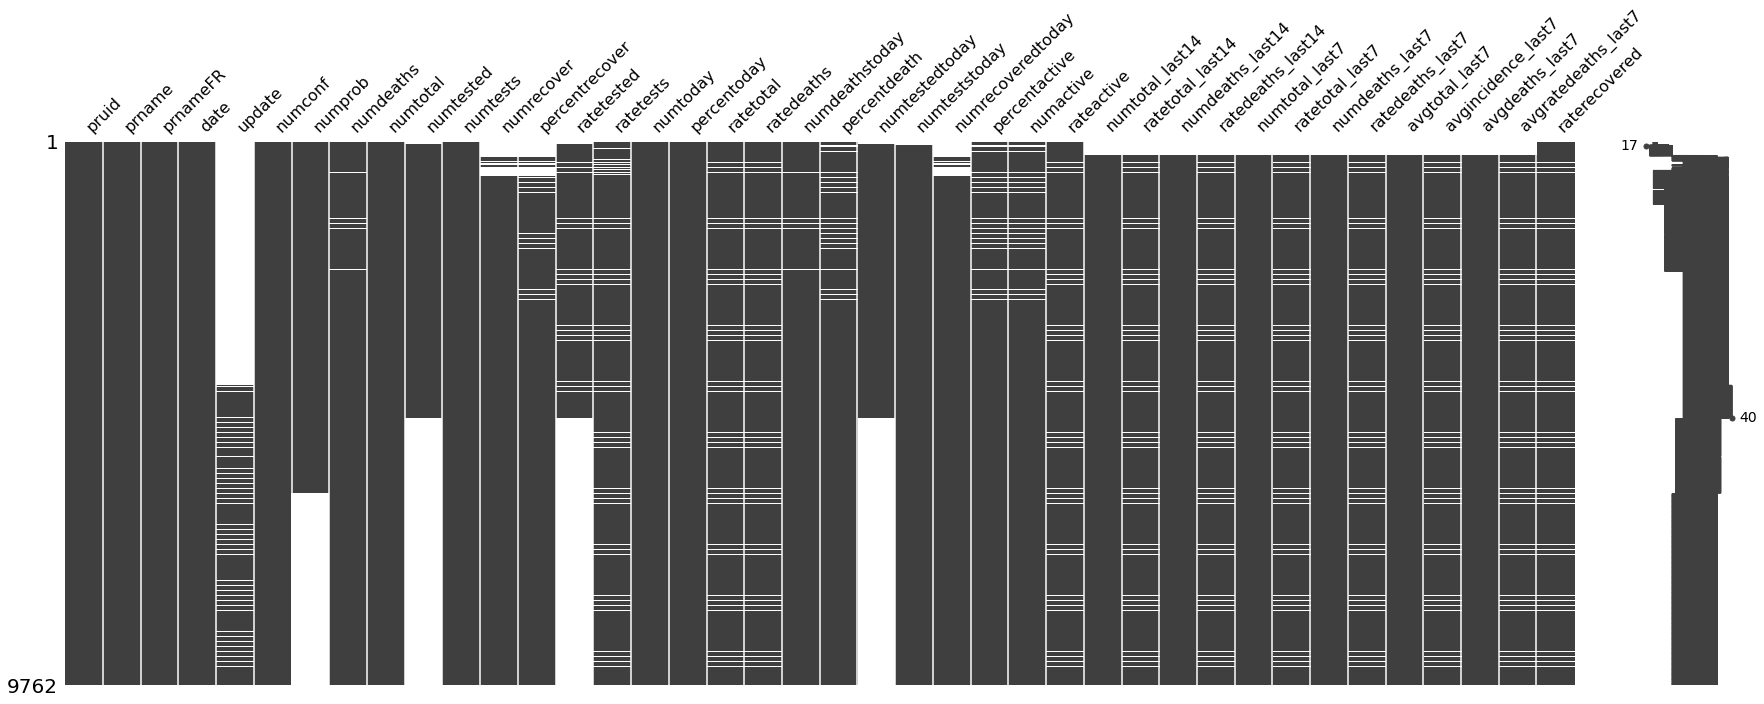

In [9]:
# Plot graphic of missing data for epi_data
msno.matrix(epi_data, figsize=(30, 10))

<AxesSubplot:>

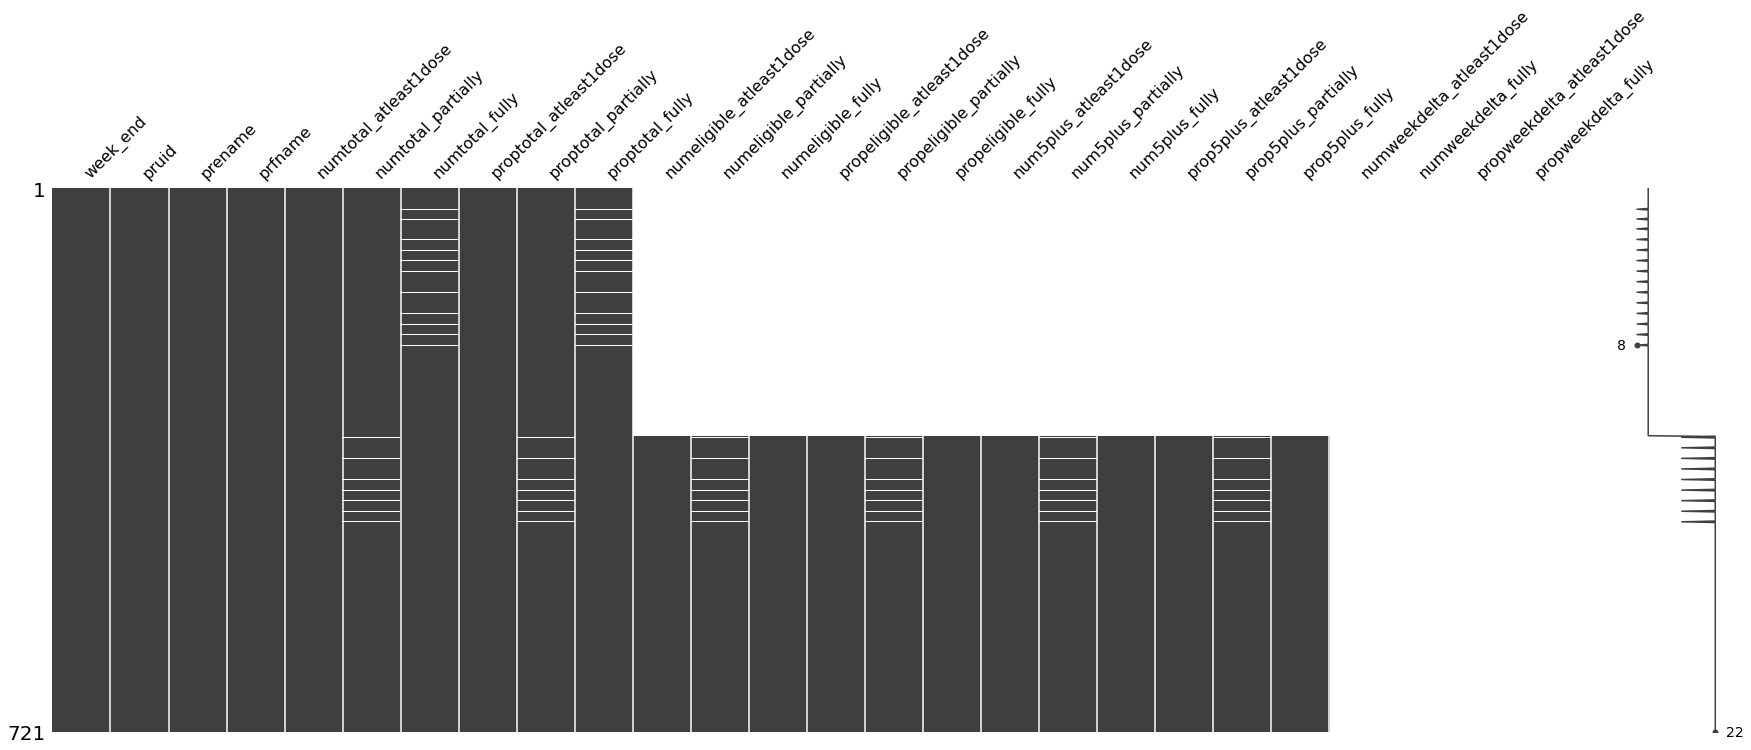

In [10]:
# Plot graphic for missing data for vax_data
msno.matrix(vax_data, figsize=(30, 10))

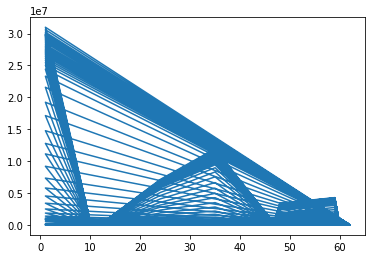

In [11]:
plt.plot(vax_data["pruid"], vax_data["numtotal_atleast1dose"])